In [1]:
# MSc Cyber Security Project — Pratham Shrestha
# Investigating Random Forest within Machine Learning-based Intrusion Detection
# Notebook 01 — EDA and Data Cleaning

# This cell sets up the basic libraries and paths used throughout the notebook.
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = Path("..") if Path.cwd().name == "notebooks" else Path(".")
DATA_RAW = BASE / "dataset" / "raw" / "ALLFLOWMETER_HIKARI2021.csv"  
FIG_DIR = BASE / "results" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 100)


In [3]:
# Load the raw CSV. Using low_memory=False to avoid mixed dtypes warnings on large CSVs.
df = pd.read_csv(DATA_RAW, low_memory=False)
df.head()


,Unnamed: 0.1,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,0,0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0.0,742.0,1826.0,121.733333,220.736581,0.0,1448.0,5025.0,358.928571,552.239840,0.0,1448.0,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,1
1,1,1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0.0,745.0,1829.0,121.933333,221.339257,0.0,1448.0,5025.0,358.928571,552.239840,0.0,1448.0,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,1
2,2,2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0.0,744.0,1828.0,130.571429,226.803444,0.0,2896.0,5025.0,386.538462,817.479013,0.0,2896.0,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,1
3,3,3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0.0,744.0,1828.0,130.571429,226.803444,0.0,2896.0,5025.0,386.538462,817.479013,0.0,2896.0,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.

In [13]:
# Quick structure: rows, columns, basic null counts.
print("Shape:", df.shape)
display(df.dtypes.head(20))
display(df.isna().sum().sort_values(ascending=False).head(20))


Shape: (555278, 88)


Unnamed: 0.1             int64
Unnamed: 0               int64
uid                     object
originh                 object
originp                  int64
responh                 object
responp                  int64
flow_duration          float64
fwd_pkts_tot             int64
bwd_pkts_tot             int64
fwd_data_pkts_tot        int64
bwd_data_pkts_tot        int64
fwd_pkts_per_sec       float64
bwd_pkts_per_sec       float64
flow_pkts_per_sec      float64
down_up_ratio          float64
fwd_header_size_tot      int64
fwd_header_size_min      int64
fwd_header_size_max      int64
bwd_header_size_tot      int64
dtype: object

Unnamed: 0.1           0
Unnamed: 0             0
uid                    0
originh                0
originp                0
responh                0
responp                0
flow_duration          0
fwd_pkts_tot           0
bwd_pkts_tot           0
fwd_data_pkts_tot      0
bwd_data_pkts_tot      0
fwd_pkts_per_sec       0
bwd_pkts_per_sec       0
flow_pkts_per_sec      0
down_up_ratio          0
fwd_header_size_tot    0
fwd_header_size_min    0
fwd_header_size_max    0
bwd_header_size_tot    0
dtype: int64

In [15]:
# Adjust column names if needed.
TARGET_COL = "Label"         
TIMESTAMP_COL = "Timestamp"  # not used for splitting in this basic pipeline, but kept for reference

assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found."
if TIMESTAMP_COL in df.columns:
    # Convert to datetime if present
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], errors="coerce")



Traffic class distribution:


,Class,Count,Percentage
0,Benign,347431,62.57
1,Background,170151,30.64
2,Probing,23388,4.21
3,Bruteforce,5884,1.06
4,Bruteforce-XML,5145,0.93
5,XMRIGCC CryptoMiner,3279,0.59


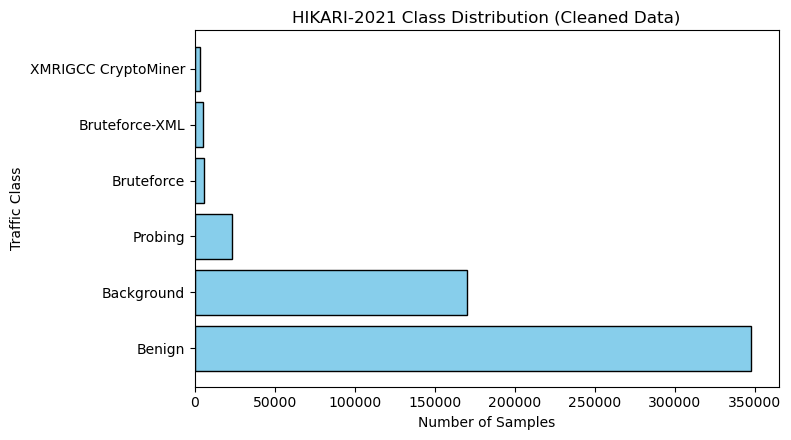

In [17]:
# The target column for this project
label_col = "traffic_category"
assert label_col in df.columns, "Target column not found!"

# Viewing class distribution
cls = df[label_col].value_counts().rename_axis("Class").reset_index(name="Count")
cls["Percentage"] = (cls["Count"] / cls["Count"].sum() * 100).round(2)

print("\nTraffic class distribution:")
display(cls)

# Save this summary for later report use
cls.to_csv(FIG_DIR / "01_class_distribution_uniqv1.csv", index=False)

plt.figure(figsize=(8, 4.5))
plt.barh(cls["Class"], cls["Count"], color="skyblue", edgecolor="black")
plt.xlabel("Number of Samples")
plt.ylabel("Traffic Class")
plt.title("HIKARI-2021 Class Distribution (Cleaned Data)")
plt.tight_layout()
plt.savefig(FIG_DIR / "01_class_distribution_uniqv1.png", dpi=300)
plt.show()



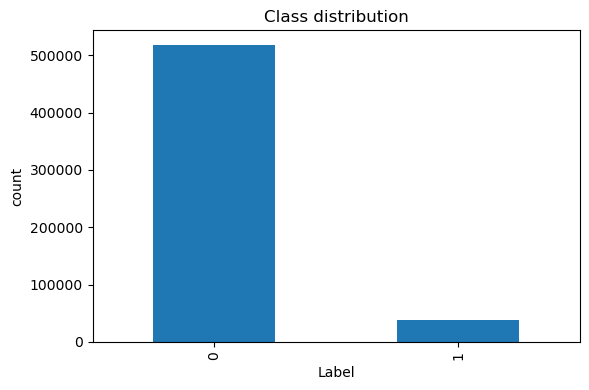

In [21]:
# --- class distribution (useful for evaluation choice) ---
class_counts = df[TARGET_COL].astype(str).value_counts()
(class_counts / class_counts.sum()).round(3)

# --- quick bar for class counts (kept super plain) ---
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar")
plt.title("Class distribution")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [22]:
# Select numeric columns to understand ranges and possible scaling needs.
num_cols = [c for c in df.columns if c != TARGET_COL and np.issubdtype(df[c].dtype, np.number)]
display(df[num_cols].describe().T.head(20))


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0.1,555278.0,277638.500000,160295.095724,0.0,138819.250000,277638.500000,416457.750000,5.552770e+05
Unnamed: 0,555278.0,137369.392132,99946.804651,0.0,52201.000000,121610.500000,211889.750000,3.507090e+05
originp,555278.0,38673.198034,18071.825216,21.0,28581.000000,42693.500000,53120.000000,6.553500e+04
responp,555278.0,5082.161647,12915.812900,0.0,53.000000,443.000000,443.000000,6.552200e+04
flow_duration,555278.0,9.306544,101.802730,0.0,0.000311,0.026218,0.347231,1.739303e+04
fwd_pkts_tot,555278.0,18.264091,463.901484,0.0,1.000000,2.000000,10.000000,3.262920e+05
bwd_pkts_tot,555278.0,18.892578,469.078877,0.0,1.000000,2.000000,12.000000,3.268270e+05
fwd_data_pkts_tot,555278.0,7.956928,73.441224,0.0,1.000000,2.000000,3.000000,3.953000e+03
bwd_data_pkts_tot,555278.0,15.803417,467.349374,0.0,0.000000,2.000000,5.000000,3.268220e+05
fwd_pkts_per_sec,555278.0,1720.704202,4994.579973,0.0,4.430152,39.760205,80.376058,2.236962e+05
